In [1]:
import pathlib

# umap analysis of treatment groups
# using warnings to ignore the deprecation warnings upon importing umap and numba
# these are annoying and not useful for the analysis output
import warnings

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import toml
import umap
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

# post hoc test for 'VEGF-C [NSU]' column using Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lippincm/miniconda3/envs/Interstellar/lib/pyth

In [2]:
# set the path of import files
cytokines_path = pathlib.Path("./results/cytokines.csv")
filtered_path = pathlib.Path(
    f"../../Data/clean/Plate2/nELISA_plate_430420_PBMC_cleanup4correlation.csv"
)
treatment_list_path = pathlib.Path(
    "../../../1.Exploratory_Data_Analysis/utils/params.toml"
)
# import data
cytokines = pd.read_csv(cytokines_path)

df = pd.read_csv(filtered_path)

In [3]:
# read in the toml file
params = toml.load(treatment_list_path)
list_of_treatments = params["list_of_treatments"]["treatments"]

In [4]:
# subset the df to have treatments that are in the list of treatments
df = df[df["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(list_of_treatments)]
df.reset_index(drop=True, inplace=True)

In [5]:
# convert cytokines to a list
cytokines_list = cytokines["cytokine"].tolist()
# subset the filtered_df with cytokines_list
df_cytokine = df[cytokines_list]
df_cytokine.reset_index(drop=True, inplace=True)

### UMAP of selected cytokines across all treatments
The cytokines were selected from the previous notebook.  
Each cytokine was selected via ANOVA and post-hoc tests followed by a manual selection of cytokines that differed between pyroptotic and apoptotic treatments.

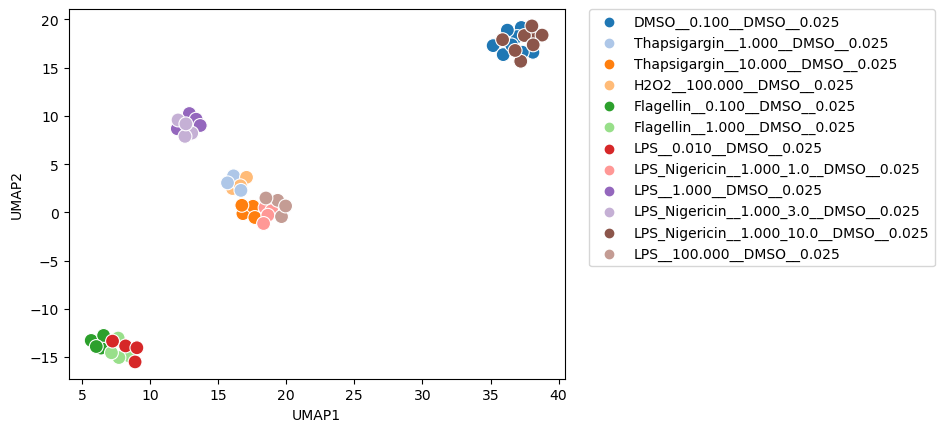

In [6]:
# define the reducer
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=1,
    random_state=0,
)
# fit the reducer
embedding = reducer.fit_transform(df_cytokine)
# create a dataframe from the embedding
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
# add the treatment groups to the embedding df
embedding_df["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"] = df[
    "fourb_Metadata_Treatment_Dose_Inhibitor_Dose"
]
# plot the embedding
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    data=embedding_df,
    hue="fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    palette="tab20",
    s=100,
)

# get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# create a dictionary to map the labels to the treatments
label_dict = dict(zip(labels, list_of_treatments))
# map the labels to the treatments
labels = [label_dict[label] for label in labels]
# create a new legend
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.savefig("figures/umap_on_selected_features.png", dpi=300, bbox_inches="tight")
# show the plot
plt.show()

### UMAP of selected cytokines across selected treatments
Here we show the UMAP of the selected cytokines across the selected treatments: DMSO, LPS, and Thapsigargin.  
These treatments were selected to show Control, Pyroptosis and Apoptosis respectively.

In [7]:
# set the treatments to plot
treatment_lst = [
    "DMSO__0.100__DMSO__0.025",
    "Thapsigargin__10.000__DMSO__0.025",
    "LPS__100.000__DMSO__0.025",
]

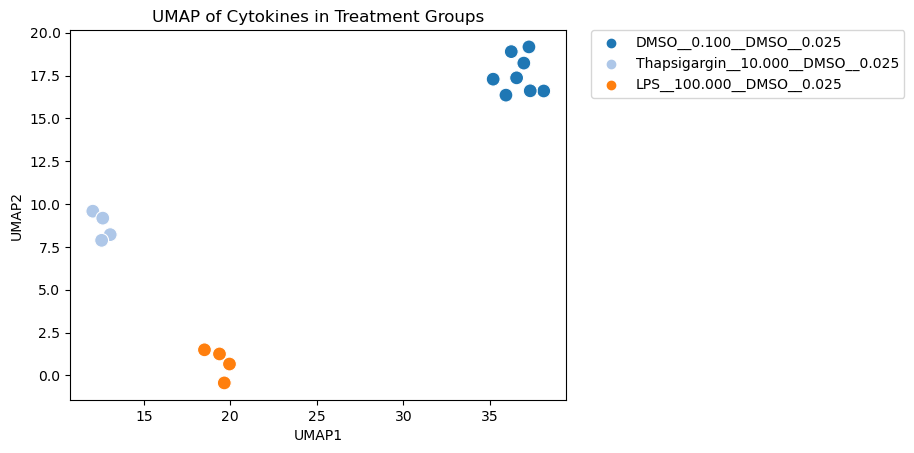

In [8]:
# subset df by treatment_lst in Inducer1_and_dose column
df_treatment = embedding_df[
    embedding_df["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"].isin(treatment_lst)
]
df_treatment = df_treatment.reset_index(drop=True)

# get the columns to umap with columns that contain '[NSU]'
column_list = [col for col in df_treatment.columns if "[NSU]" in col]
# subset columns in df from column_list
df_cytokine = df_treatment[column_list]
treatment_col = df_treatment["fourb_Metadata_Treatment_Dose_Inhibitor_Dose"]

# plot the embedding
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    data=df_treatment,
    hue="fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
    palette="tab20",
    s=100,
)
plt.title("UMAP of Cytokines in Treatment Groups")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

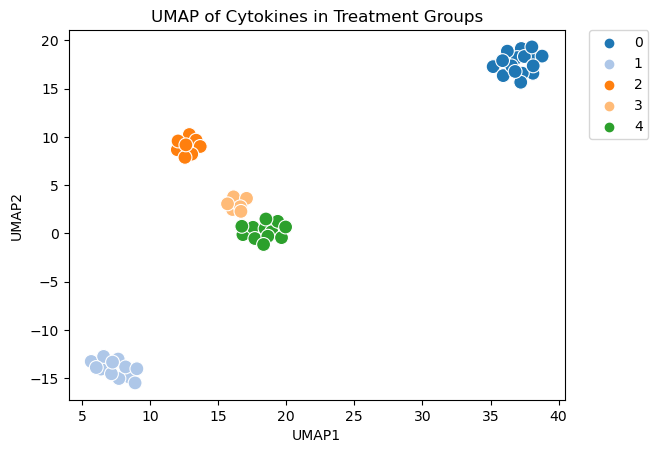

In [9]:
# get cluster labels
cluster = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1).fit_predict(
    embedding_df[["UMAP1", "UMAP2"]]
)
# add the cluster labels to the embedding df
embedding_df["cluster"] = cluster
# plot the embedding
sns.scatterplot(
    x="UMAP1", y="UMAP2", data=embedding_df, hue="cluster", palette="tab20", s=100
)
plt.title("UMAP of Cytokines in Treatment Groups")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

Based on these clustering, it seems that the selected cytokines are enough to seperate the treatments.  
We can see that the LPS treatments are seperated from the Thapsigargin treatments.  
The variability of cytokine levels in enought to seperate the treatments. We can move forward with further investigation of these cytokines.